In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
!ls
%cd drive
!ls
%cd MyDrive

MyDrive
[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive
MyDrive


In [ ]:
%cd MyDrive

In [9]:
%cd shiz
!ls

/content/drive/MyDrive/shiz
df_main_all_features_26jan.xlsx  PsychiatricDiscourse_participant.data.xlsx


In [26]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.8 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/google/colab/_pip.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.8/dist-packages/pyaml-21.10.1.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):
/usr/local/lib/python3.8/dist-packages/google/colab/_pip.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.8/dist-packages/scikit_optimize-0.9.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [11]:
import pandas as pd
import numpy as np

In [12]:
df = pd.read_excel('df_main_all_features_26jan.xlsx')   #/content/
df = df.set_index('ID')
df.age = df.age.fillna(df.age.mean())
df = df.dropna()
df.head(1)

,sex,age,education_lvl,education_years,depression,tds,id,chroma_cens,chroma_cqt,chroma_stft,...,spectral_flatness_avg,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,17.0,0,10,0,0,PD-003,[[1.11672273e-01 1.17649218e-01 1.24970686e-01...,[[0.19607635 0.21339749 0.24352823 ... 0.34575...,[[0.7175596 0.799478 0.88265824 ... 0.18122...,...,0.010274,0.021415,3650.894661,1749.280332,0.213538,0.237341,0.022909,0.091652,0.084568,0.081494


In [13]:
df.tds.value_counts()

0    150
1     16
2      3
Name: tds, dtype: int64

In [14]:
df["tds"] = df.tds.replace({2: 1}) #there are only 3 people in class 2, so it is ok to replace 2 to 1, so that we have binary class-ion
df.tds.value_counts()

0    150
1     19
Name: tds, dtype: int64

In [15]:
df_clean = df.drop(['age', 'education_lvl', 'education_years', 'sex', 'depression', 'chroma_cens', 'chroma_cqt', 'id', 'chroma_stft',
    'melspectrogram', 'mfcc', 'poly_features', 'rmfourier_tempograms', 'rms', 'spectral_bandwidth', 'spectral_centroid',
    'spectral_contrast', 'spectral_flatness', 'spectral_rolloff', 'tempogram', 'tonnetz', 'zero_crossing_rate', 'mfcc_avg',
    'rms_avg'], axis=1)

In [16]:
X = df_clean.drop(['tds'], axis=1) # Features , 'rmfourier_tempograms_avg'
y = df.tds # Target variable

**Logreg all features**

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)  
          
clf.fit(X_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.9218181818181819


In [19]:
warnings.filterwarnings('default')

In [20]:
logreg = LogisticRegression(solver='newton-cg', max_iter=6000, penalty = 'l2', C=0.001) #, class_weight = 'balanced' 'C': 0.1,  'penalty': 'l2',  'solver': 'liblinear'
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        60
           1       0.71      0.62      0.67         8

    accuracy                           0.93        68
   macro avg       0.83      0.80      0.81        68
weighted avg       0.92      0.93      0.92        68

0.9264705882352942


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['recall', 'accuracy', 'f1']
scores = cross_validate(logreg, X, y, scoring=scoring)
scores

{'fit_time': array([0.21410584, 0.19155979, 0.17713857, 0.16179037, 0.16531491]),
 'score_time': array([0.00521469, 0.00539851, 0.00515771, 0.00512171, 0.00577974]),
 'test_recall': array([0.25      , 0.5       , 1.        , 0.25      , 0.33333333]),
 'test_accuracy': array([0.88235294, 0.91176471, 0.91176471, 0.91176471, 0.93939394]),
 'test_f1': array([0.33333333, 0.57142857, 0.72727273, 0.4       , 0.5       ])}

**Random forest all features**

In [27]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100)
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.9010695187165775
test score: 0.8970588235294118
best_params: OrderedDict([('max_depth', 95), ('n_estimators', 100)])


In [28]:
opt.best_params_

OrderedDict([('max_depth', 95), ('n_estimators', 100)])

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=444, 
                          #   class_weight = "balanced",
                             max_depth = 71)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        60
           1       0.75      0.38      0.50         8

    accuracy                           0.91        68
   macro avg       0.84      0.68      0.73        68
weighted avg       0.90      0.91      0.90        68



In [30]:
cross_validate(rfc, X, y, scoring=scoring)

{'fit_time': array([0.97828913, 1.24949503, 0.87206054, 0.61400342, 0.61424255]),
 'score_time': array([0.07324576, 0.06608129, 0.0445416 , 0.04133701, 0.03939295]),
 'test_recall': array([0.25      , 0.        , 0.25      , 0.25      , 0.33333333]),
 'test_accuracy': array([0.88235294, 0.82352941, 0.91176471, 0.91176471, 0.84848485]),
 'test_f1': array([0.33333333, 0.        , 0.4       , 0.4       , 0.28571429])}

**Support Vector Machine all features**

In [31]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8), 
        'kernel': ['linear', 'poly', 'rbf'], 
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.8912655971479501
test score: 0.8823529411764706


In [32]:
opt.best_params_

OrderedDict([('C', 237.42906456403173),
             ('degree', 3),
             ('gamma', 0.6836481375822575),
             ('kernel', 'rbf')])

In [33]:
from sklearn import svm

clf = svm.SVC(C = 0.00017834450048694595, degree = 1, gamma = 1e-06, kernel = 'linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [34]:
print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        60
           1       0.67      0.50      0.57         8

    accuracy                           0.91        68
   macro avg       0.80      0.73      0.76        68
weighted avg       0.90      0.91      0.91        68

0.9117647058823529


In [35]:
cross_validate(clf, X, y, scoring=scoring)

{'fit_time': array([0.01100612, 0.00541711, 0.00971198, 0.00591397, 0.01035476]),
 'score_time': array([0.00421715, 0.00383258, 0.00329614, 0.00416565, 0.00350761]),
 'test_recall': array([0.  , 0.  , 0.75, 0.25, 0.  ]),
 'test_accuracy': array([0.88235294, 0.88235294, 0.94117647, 0.91176471, 0.90909091]),
 'test_f1': array([0.  , 0.  , 0.75, 0.4 , 0.  ])}

**MLP all features**

In [36]:
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [37]:
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)

In [38]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits

#https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html
opt = BayesSearchCV(
    MLPClassifier(),
    {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'random_state': [1, 2, 3],
    },
    n_iter=32,
    cv=3
)

opt.fit(X_trainscaled, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_testscaled, y_test))

val. score: 0.9013666072489602
test score: 0.8676470588235294


In [39]:
opt.best_params_

OrderedDict([('activation', 'relu'), ('random_state', 3)])

In [40]:
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=3).fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

0.8529411764705882


In [41]:
print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92        60
           1       0.25      0.12      0.17         8

    accuracy                           0.85        68
   macro avg       0.57      0.54      0.54        68
weighted avg       0.82      0.85      0.83        68

0.8529411764705882


**Lets clean our feature-list according to the chart**

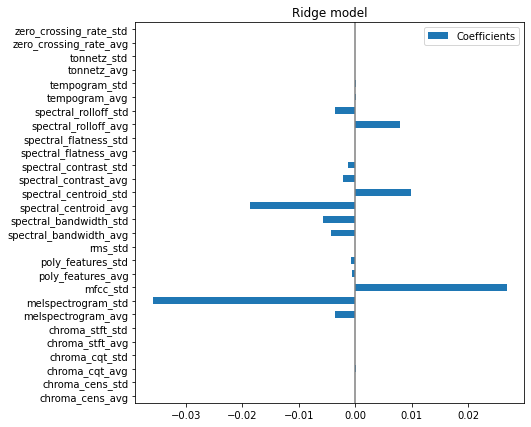

In [42]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   logreg.coef_.T,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [43]:
coefs.apply(lambda x: abs(x)).sort_values(by='Coefficients', ascending=False).head(11)

,Coefficients
melspectrogram_std,0.035828
mfcc_std,0.026833
spectral_centroid_avg,0.018575
spectral_centroid_std,0.009899
spectral_rolloff_avg,0.007922
spectral_bandwidth_std,0.005630
spectral_bandwidth_avg,0.004250
spectral_rolloff_std,0.003581
melspectrogram_avg,0.003522
spectral_contrast_avg,0.002188


In [ ]:
logreg_feature_cols = ['tempogram_std', 'tempogram_avg', 'chroma_cqt_avg',  'melspectrogram_avg', 'spectral_contrast_avg', 
                       'chroma_stft_avg', 'chroma_cens_avg', 'tonnetz_std', 'spectral_contrast_avg', 'chroma_stft_std', 'tds']
logreg_filtered_df = df_upsample_clean[logreg_feature_cols]
X = logreg_filtered_df.drop(['tds'], axis=1)
y = logreg_filtered_df.tds

**Logreg with cleaned features**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=3000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       0.53      0.51      0.52        59
           1       0.55      0.56      0.56        62

    accuracy                           0.54       121
   macro avg       0.54      0.54      0.54       121
weighted avg       0.54      0.54      0.54       121

0.5371900826446281


Really bad actually =)

In [ ]:
cross_validate(logreg, X1, y, scoring=scoring)

{'fit_time': array([0.0331111 , 0.03928089, 0.02874613, 0.01969671, 0.02937365]),
 'score_time': array([0.00541997, 0.01312876, 0.0058794 , 0.00557876, 0.00563359]),
 'test_recall': array([0.67741935, 0.70967742, 0.66666667, 0.7       , 0.66666667]),
 'test_accuracy': array([0.67213115, 0.50819672, 0.55      , 0.66666667, 0.63333333]),
 'test_f1': array([0.67741935, 0.59459459, 0.59701493, 0.67741935, 0.64516129])}

**Random forest with cleaned features**

Text(0.5, 0, 'Random Forest Feature Importance')

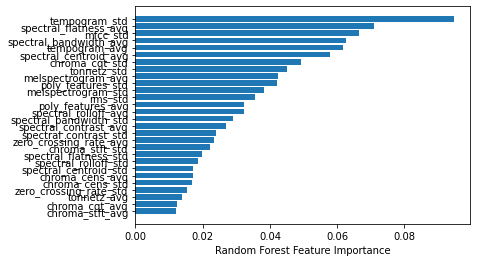

In [ ]:
from sklearn.inspection import permutation_importance
sorted_idx = rfc.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
X.columns[sorted_idx][15:]

Index(['poly_features_avg', 'rms_std', 'melspectrogram_std',
       'poly_features_std', 'melspectrogram_avg', 'tonnetz_std',
       'chroma_cqt_std', 'spectral_centroid_avg', 'tempogram_avg',
       'spectral_bandwidth_avg', 'mfcc_std', 'spectral_flatness_avg',
       'tempogram_std'],
      dtype='object')

In [ ]:
rfc_feature_cols = X.columns[sorted_idx][15:]
rfc_X = df_upsample_clean[rfc_feature_cols]
y = df_upsample_clean.tds # Target variable

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rfc_X, y, test_size=0.4, random_state=16)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.95      1.00      0.98        62

    accuracy                           0.98       121
   macro avg       0.98      0.97      0.98       121
weighted avg       0.98      0.98      0.98       121

0.9752066115702479


In [ ]:
cross_validate(clf, X, y, scoring=scoring)

{'fit_time': array([0.28826952, 0.89900112, 0.28104353, 0.54367781, 0.30875802]),
 'score_time': array([0.00713205, 0.00647736, 0.00653386, 0.00715518, 0.00643873]),
 'test_recall': array([0.93548387, 0.96774194, 1.        , 0.2       , 1.        ]),
 'test_accuracy': array([0.47540984, 0.81967213, 0.5       , 0.55      , 0.58333333]),
 'test_f1': array([0.64444444, 0.84507042, 0.66666667, 0.30769231, 0.70588235])}

Bad too😥 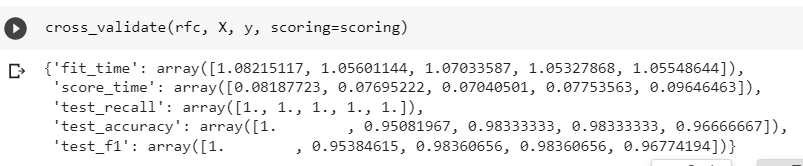